In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import datetime
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from tqdm import tqdm_notebook
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow.python'

In [4]:
data= pd.read_csv('preprocessed_data_v1.csv', low_memory=False)

In [5]:
#data = data[['UID', 'Domain','Time', 'category_1', 'category_2', 'PC', 'session_id']]

In [6]:
#data.to_csv('preprocessed_data_v1.csv')

In [7]:
data['Time'] = pd.to_datetime(data['Time'])

In [8]:
data = data.dropna()

In [9]:
#label encoding
encoder = LabelEncoder()

In [10]:
data['category_1'] = encoder.fit_transform(data['category_1'])
data['category_2'] = encoder.fit_transform(data['category_2'])

In [11]:
data.head()

,Unnamed: 0,UID,Domain,Time,category_1,category_2,PC,session_id
0,0,20120712210FAAE99B43,cjmall.com/,2014-06-01 14:07:26,5,237,0,0
1,1,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:31,5,270,0,1
2,2,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:34,5,270,0,1
3,3,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:40,5,270,0,1
4,4,20120712210FAAE99B43,naver.com/,2014-06-01 14:25:46,13,211,0,1


### 세션당 방문한 사이트 수 

In [12]:
#session 당 방문한 사이트 수
data = pd.merge(data,pd.DataFrame(data.groupby(['UID', 'session_id']).count()['Domain']),
                        left_on = ['UID', 'session_id'], right_on = ['UID', 'session_id'])

### 구매 데이터 분석

In [13]:
purchase = pd.read_excel('140716_SSK 구매행태 조사 Raw Data_F.xlsx')

In [14]:
purchase.head()

,UID,SQ1,SQ2,A1#1,A1#2,A1#ETC10,A2_1,A2_1#ETC4,A2_2,A2_2#ETC5,...,DQ2,DQ3,DQ3#ETC6,DQ4,MARRIAGE,FAMILY_SET_1,FAMILY_SET_2,FAMILY_SET_3,FAMILY_SET_4,FAMILY_SET_5
0,2012080964C51FADA0BB,2,1,4,3,NaN,NaN,NaN,NaN,NaN,...,1,1,NaN,1,1,2,NaN,NaN,NaN,NaN
1,201208101CC2B1B38E1A,5,1,2,4,NaN,NaN,NaN,3.0,NaN,...,1,2,NaN,4,2,3,6.0,NaN,NaN,NaN
2,201208109732058C1B6F,7,2,2,5,NaN,NaN,NaN,3.0,NaN,...,3,2,NaN,2,4,6,NaN,NaN,NaN,NaN
3,201208111F4AD56E8439,3,1,2,4,NaN,NaN,NaN,2.0,NaN,...,6,3,NaN,2,1,2,5.0,NaN,NaN,NaN
4,2012081342E07944430F,5,1,2,4,NaN,NaN,NaN,3.0,NaN,...,9,3,NaN,2,2,3,6.0,NaN,NaN,NaN


In [15]:
purchase.isna().sum()['A4_2_1']

528

In [16]:
#가전제품 구입자(인터넷에서 정보를 얻은 사람들)
purchase_가전제품 = purchase[(purchase['A4_2_1'] == 3) & ((purchase['A4_5'] == 3) | (purchase['A4_5'] == 4))]
#패션의류/잡화 구입자(인터넷에서 정보를 얻은 사람들)
purchase_패션 = purchase[(purchase['A5_2_1'] == 3) & ((purchase['A5_5'] == 3) | (purchase['A5_5'] == 4))]
#화장품 구입자(인터넷에서 정보를 얻은 사람들)
purchase_화장품 = purchase[(purchase['A6_2_1'] == 3) & ((purchase['A6_5'] == 3) | (purchase['A6_5'] == 4))]
#186명이라 중순과 하순만 고려해야 할듯

In [17]:
print(purchase_가전제품.shape)
print(purchase_패션.shape)
print(purchase_화장품.shape)

(98, 151)
(190, 151)
(155, 151)


In [18]:
data = pd.merge(data,purchase[['UID','A4_2_1','A4_2_2', 'A5_2_1','A5_2_2' ,'A6_2_1','A6_2_2' ,'A4_5', 'A5_5', 'A6_5']],
                how = 'left',left_on = 'UID', right_on= 'UID')

In [19]:
data.head()

,Unnamed: 0,UID,Domain_x,Time,category_1,category_2,PC,session_id,Domain_y,A4_2_1,A4_2_2,A5_2_1,A5_2_2,A6_2_1,A6_2_2,A4_5,A5_5,A6_5
0,0,20120712210FAAE99B43,cjmall.com/,2014-06-01 14:07:26,5,237,0,0,1,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0
1,1,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:31,5,270,0,1,6,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0
2,2,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:34,5,270,0,1,6,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0
3,3,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:40,5,270,0,1,6,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0
4,4,20120712210FAAE99B43,naver.com/,2014-06-01 14:25:46,13,211,0,1,6,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0


## 가전제품 구입자 분류(0: 미구입, 1:6월 중순 구입, 2: 6월 하순 구입)

In [20]:
data.drop('Unnamed: 0', axis= 1, inplace= True)

In [21]:
data.shape

(37068659, 17)

In [22]:
data.isna().sum()

UID                  0
Domain_x             0
Time                 0
category_1           0
category_2           0
PC                   0
session_id           0
Domain_y             0
A4_2_1        20706379
A4_2_2        20706379
A5_2_1        14098152
A5_2_2        14098152
A6_2_1        17019260
A6_2_2        17019260
A4_5          20706379
A5_5          14098152
A6_5          17019260
dtype: int64

In [23]:
#결측값 0으로 대체
data = data.fillna(0)

In [24]:
data['가전제품구매'] = 0 

In [25]:
#6월 중순 구입자
data.loc[((data.A4_2_1==3) & (data.A4_2_2==2)), '가전제품구매'] = 1

#6월 하순 구입자
data.loc[((data.A4_2_1==3) & (data.A4_2_2==3)), '가전제품구매'] = 2

In [26]:
data.rename(columns ={'Domain_y': '세션당_방문사이트수'}, inplace= True)

In [27]:
data.head()

,UID,Domain_x,Time,category_1,category_2,PC,session_id,세션당_방문사이트수,A4_2_1,A4_2_2,A5_2_1,A5_2_2,A6_2_1,A6_2_2,A4_5,A5_5,A6_5,가전제품구매
0,20120712210FAAE99B43,cjmall.com/,2014-06-01 14:07:26,5,237,0,0,1,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0,0
1,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:31,5,270,0,1,6,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0,0
2,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:34,5,270,0,1,6,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0,0
3,20120712210FAAE99B43,uplus.co.kr/,2014-06-01 14:25:40,5,270,0,1,6,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0,0
4,20120712210FAAE99B43,naver.com/,2014-06-01 14:25:46,13,211,0,1,6,1.0,2.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0,0


## 패션, 화장품 구입자들

In [28]:
data['패션구매'] = 0
data['화장품구매'] = 0

In [29]:
#6월 중순 구입자
data.loc[((data.A5_2_1==3) & (data.A5_2_2==2)), '패션구매'] = 1

#6월 하순 구입자
data.loc[((data.A5_2_1==3) & (data.A5_2_2==3)), '패션구매'] = 2

#6월 중순 구입자
data.loc[((data.A6_2_1==3) & (data.A6_2_2==2)), '화장품구매'] = 1

#6월 하순 구입자
data.loc[((data.A6_2_1==3) & (data.A6_2_2==3)), '화장품구매'] = 2

### RNN을 위한 전처리

In [30]:
def make_XY(df, category):
    df = df.set_index('UID')
    X = df[['category_1','세션당_방문사이트수']]
    Y = df[[category + '구매']]
    X = X.reset_index()
    X = pd.concat([X,pd.get_dummies(X['category_1'])], axis = 1)
    Y = Y.groupby(Y.index).first()
    new_Y = Y[category + '구매']
    return X,new_Y

In [31]:
X_가전제품,Y_가전제품 = make_XY(data,'가전제품')
X_패션,Y_패션 = make_XY(data, '패션')
X_화장품,Y_화장품 = make_XY(data, '화장품')

In [32]:
X_패션.head()

,UID,category_1,세션당_방문사이트수,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,20120712210FAAE99B43,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,20120712210FAAE99B43,5,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,20120712210FAAE99B43,5,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,20120712210FAAE99B43,5,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,20120712210FAAE99B43,13,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### 3차원 array로 만드는 과정

In [33]:
def make_3D_array(X):
    new_X = []
    for UID in tqdm_notebook(X['UID'].unique()):
        temp = X[X['UID'] == UID]
        new_X.append(temp.iloc[:,2:].values)
    new_X = np.asarray(new_X)
    return new_X

In [34]:
new_X_화장품 = make_3D_array(X_화장품)

In [35]:
new_X_패션 = make_3D_array(X_패션)

In [36]:
new_X_가전제품 = make_3D_array(X_가전제품)

### 3d화 과정이 오래걸리니 csv파일로 저장

In [37]:
pd.DataFrame(Y_가전제품).to_csv('Y_가전제품.csv')
pd.DataFrame(Y_패션).to_csv('Y_패션.csv')
pd.DataFrame(Y_화장품).to_csv('Y_화장품.csv')

### Oversampling

In [80]:
sequence.pad_sequences(new_X_화장품, maxlen= 5000).shape

(2103, 5000, 16)

In [38]:
def make_padding_and_oversample(X, Y):
    max_len = 5000
    X_padding = sequence.pad_sequences(X, maxlen = max_len)
    X_padding2 = X_padding.reshape(X.shape[0], max_len* X_padding.shape[2])
    smote = SMOTE(random_state=0)
    X_resampled, Y_resampled = smote.fit_resample(X_padding2, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, X_padding.shape[2])
    return X_padding, X_resampled, Y_resampled

In [39]:
X_가전제품_padded, X_가전제품_resampled, Y_가전제품_resampled =make_padding_and_oversample(new_X_가전제품, Y_가전제품)
X_패션_padded,X_패션_resampled, Y_패션_resampled =make_padding_and_oversample(new_X_패션, Y_패션)
X_화장품_padded,X_화장품_resampled, Y_화장품_resampled =make_padding_and_oversample(new_X_화장품, Y_화장품)

In [40]:
df1 = pd.DataFrame(X_패션_padded.reshape(2103, 5000*16))
df1.to_csv('패션_3d_array.csv', index=False)
df2 = pd.DataFrame(X_가전제품_padded.reshape(2103, 5000*16))
df2.to_csv('가전제품_3d_array.csv', index=False)
df3 = pd.DataFrame(X_화장품_padded.reshape(2103, 5000*16))
df3.to_csv('화장품_3d_array.csv', index=False)

### LSTM 가동

In [52]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 패션

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
X_패션_resampled, Y_패션_resampled, test_size=0.3, random_state=42)

In [54]:

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [55]:
X_train.shape

(3790, 5000, 16)

In [48]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 5000, 16)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total params: 23,395
Trainable params: 23,395
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 4130 samples, validate on 1771 samples
Epoch 1/25
 - 78s - loss: 1.0931 - acc: 0.3753 - val_loss: 1.0687 - val_acc: 0.4365
Epoch 2/25
 - 77s - loss: 1.0620 - acc: 0.4559 - val_loss: 1.0346 - val_acc: 0.5014
Epoch 3/25
 - 76s - loss: 1.0333 - acc: 0.4879 - val_loss: 1.0044 - val_acc: 0.5110
Epoch 4/25
 - 77s - loss: 1.0020 - acc: 0.5133 - val_loss: 0.9962 - val_acc: 0.5189
Epoch 5/25
 - 77s - loss: 0.9707 - acc: 0.5431 - val_loss: 0.9008 - val_acc: 0.6002
Epoch 6/25
 - 77s - loss: 0.8927 - acc: 0.6058 - val_loss: 0.9744 - val_acc: 0.4952
Epoch 7/25
 - 76s - loss: 0.9199 - acc: 0.5538 - val_loss: 0.8197 - val_acc: 0.6217
Epoch 8/25
 - 77s - loss: 0.8173 - acc: 0.6254 - val_loss: 0.7889 - val_acc: 0.6302
Epoch 9/25
 - 77s - loss: 0.7974 - acc: 0.6254 - val_loss: 0.8906 - val_acc: 0.5381
Epoch 10/25
 - 77s - loss: 0.8429 - acc: 0.5959 - val_loss: 0.7801 - val_acc: 0.6426
Epoch 11/25
 - 77s - loss: 0.9150 - acc: 0.5518 - val_loss: 0.7505 - val_acc: 0.6584
Epoch 12/25
 - 76s - loss:

In [50]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [51]:
#가전제품 f1-score: 0.7819220343082984
#패션 accuracy: 0.7188029361269287

print(accuracy)

0.7188029361269287


#### 가전제품

In [94]:
X_가전제품_resampled.shape

(5415, 5000, 16)

In [95]:
Y_가전제품_resampled.shape

(5901,)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
X_가전제품_resampled, Y_가전제품_resampled, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, 5000, 16)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 51        
Total params: 23,395
Trainable params: 23,395
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 4130 samples, validate on 1771 samples
Epoch 1/50
 - 60s - loss: 1.0900 - acc: 0.3889 - val_loss: 1.0737 - val_acc: 0.4178
Epoch 2/50
 - 59s - loss: 1.0695 - acc: 0.4073 - val_loss: 1.0501 - val_acc: 0.4190
Epoch 3/50
 - 59s - loss: 1.0445 - acc: 0.4317 - val_loss: 1.0212 - val_acc: 0.5150
Epoch 4/50
 - 57s - loss: 1.0100 - acc: 0.4952 - val_loss: 0.9886 - val_acc: 0.5353
Epoch 5/50
 - 60s - loss: 0.9797 - acc: 0.5143 - val_loss: 0.9621 - val_acc: 0.5551
Epoch 6/50
 - 61s - loss: 0.9343 - acc: 0.5508 - val_loss: 0.9309 - val_acc: 0.5539
Epoch 7/50
 - 64s - loss: 0.9189 - acc: 0.5535 - val_loss: 0.8388 - val_acc: 0.6200
Epoch 8/50
 - 60s - loss: 0.9078 - acc: 0.5576 - val_loss: 0.8137 - val_acc: 0.6364
Epoch 9/50
 - 60s - loss: 0.8435 - acc: 0.5881 - val_loss: 0.7790 - val_acc: 0.6477
Epoch 10/50
 - 60s - loss: 0.7786 - acc: 0.6177 - val_loss: 0.7865 - val_acc: 0.6318
Epoch 11/50
 - 60s - loss: 0.8252 - acc: 0.5969 - val_loss: 0.7268 - val_acc: 0.6612
Epoch 12/50
 - 59s - loss:

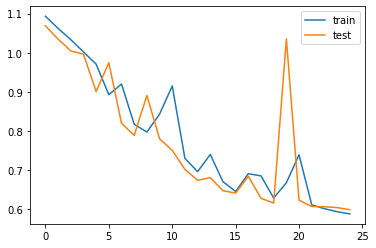

In [52]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()                       

In [53]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [56]:
#가전제품 f1-score: 0.7819220343082984

print(accuracy)

0.7188029361269287


#### 화장품

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
X_화장품_resampled, Y_화장품_resampled, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [58]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 5000, 16)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 23,395
Trainable params: 23,395
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
history = model.fit(X_train, y_train, epochs=50, batch_size=1000, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 3916 samples, validate on 1679 samples
Epoch 1/50
 - 51s - loss: 0.6749 - acc: 0.6338 - val_loss: 0.6493 - val_acc: 0.6367
Epoch 2/50
 - 51s - loss: 0.6732 - acc: 0.6404 - val_loss: 0.6465 - val_acc: 0.6355
Epoch 3/50
 - 52s - loss: 0.6689 - acc: 0.6456 - val_loss: 0.6563 - val_acc: 0.6403
Epoch 4/50
 - 51s - loss: 0.6811 - acc: 0.6369 - val_loss: 0.6383 - val_acc: 0.6504
Epoch 5/50
 - 51s - loss: 0.6599 - acc: 0.6435 - val_loss: 0.6382 - val_acc: 0.6403
Epoch 6/50
 - 51s - loss: 0.7159 - acc: 0.6353 - val_loss: 0.9163 - val_acc: 0.5789
Epoch 7/50
 - 52s - loss: 0.8036 - acc: 0.5858 - val_loss: 0.6506 - val_acc: 0.6397
Epoch 8/50
 - 51s - loss: 0.6615 - acc: 0.6417 - val_loss: 0.6379 - val_acc: 0.6498
Epoch 9/50
 - 51s - loss: 0.6544 - acc: 0.6468 - val_loss: 0.6329 - val_acc: 0.6546
Epoch 10/50
 - 51s - loss: 0.6560 - acc: 0.6394 - val_loss: 0.6314 - val_acc: 0.6528
Epoch 11/50
 - 51s - loss: 0.6553 - acc: 0.6453 - val_loss: 0.6297 - val_acc: 0.6546
Epoch 12/50
 - 54s - loss: